### Import Modules

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import time

import warnings
warnings.filterwarnings('ignore')
%matplotlib nbagg

Simulation configuration

In [2]:
# Number of vehicles to keep track of, e.g. plot headways, positions of chosen vehicles
n_cars_plot = 4

## Lane-Changing Models

In [12]:
def prob_enter(headway, vel, density, t_cur, t_lc, n_cars_cur, beta=2.820):
    """Probability of a car entering any of the gaps inbetween vehicles

    :returns: boolean array, True if a car enters a gap
                             False if a car does not enter the gap
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    #mu_lc = 2.850 #1.9802 - 32.7937*density
    # 3.09 is the best value so far
    mu_lc = 3.1 #3.05 #2.98 #3
    sigma_lc = .3642
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_appear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    #if (t_cur%t_lc)==0 and len(headway)<38:
    if (t_cur%t_lc)==0:
        #return np.random.rand(len(headway)) < p_appear * t_lc / beta
        return np.random.rand(len(headway)) < p_appear
    else:
        return [False]*len(headway)

In [4]:
def prob_exit(headway, vel, density, t_cur, t_lc, n_cars_cur, beta=2.82):
    """Probability of cars in the lane exitting

    :returns: boolean array, True if a car exits the lane
                             False if a car does not exit the lane
    """
    
    th = headway #np.divide(headway,vel)  # time headway
    
    mu_lc = 2.7962 #2.0718 - 51.96*density
    sigma_lc = 0.4176
    
    mu_th = 2.9512 #2.05 - 48.53*density
    sigma_th = 0.4255
    
    # normalization constant
    C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
        * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
               (-2*sigma_th**2+2*sigma_lc**2)) \
        / np.sqrt(2*np.pi)
        
    p_disappear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))
    
    #if (t_cur%t_lc)==0 and len(headway)>4:
    if (t_cur%t_lc)==0 and n_cars_cur > 4:
        #return np.random.rand(len(headway)) < p_disappear * t_lc / beta
        return np.random.rand(len(headway)) < p_disappear
    else:
        return [False]*len(headway)

## Car-Following Model

In [5]:
def car_following_OVM(y, t, params, y_minus_tau):
    """Defines car-following behavior of driver-vehicle units.
       Behvaior here is specified by the Optimal Velocity Model (OVM)
    
    :y: state of the system
        - first half of the array represents the headway of the cars, ordered in decreasing position
        - second half of the array represents the velocity of the cars, ordered as they are in the position half
    :t: time interval
    :params : parameters of the OVM car-following model
              - params['alpha']  : headway gain
              - params['beta']   : relative velocity gain
              - params['tau']    : driver reaction time [s]
              - params['v_max']  : maximum velocity [m/s]
              - params['h_go']   : go headway [m]
              - params['h_st']   : stop headway [m]
    :y_minus_tau: state of the system tau seconds ago
    
    :returns: dydt - derivative of the states (y)
    """
    
    dydt = np.zeros(len(y))
    n = int(len(y)/2)
    
    for i in range(n):
        if i==0:
            vl = y[-1]                      # velocity of lead vehicle
            vl_minus_tau = y_minus_tau[-1]  # lead velocity tau seconds ago
        else:
            vl = y[n+i-1]
            vl_minus_tau = y_minus_tau[n+i-1]
    
        v = y[n+i]                      # velocity of current vehicle
        h = y_minus_tau[i]              # headway of current vehicle
        v_minus_tau = y_minus_tau[n+i]  # velocity of current vehicle tau seconds ago
        
        if h <= params['h_st']:
            V = 0
        elif h < params['h_go']:
            V = params['v_max']/2*(1-np.cos(np.pi*(h-params['h_st'])/(params['h_go']-params['h_st'])))
        else:
            V = params['v_max']
            
        dydt[i] = vl - v
        dydt[n+i] = params['alpha']*(V-v_minus_tau) + params['beta']*(vl_minus_tau-v_minus_tau)
    
    return(dydt)

## Ring Road

In [6]:
class ring_road():
    """
    Simulation of vehicles in a circular lane following the IDM model.
    Vehicles are allowed to enter and exit the lane according to the probability "prob_enter" and "prob_exit"
    Certain vehicle units of your choosing can be held constant in the model for analysis purposes
    """
    
    def __init__(self, params, n_cars, x_init, v_init, ind_cars_const):
        """Instantiates the class with the car-following model parameters
           Initializes road with a set of vehicles with inital positions and velocities
           Specifies vehicles that should not be allowed to exit the road (may be equal to zero)
        
        :params         : parameters of the car-following model, MUST CONTAIN lr and lc
                           - params['lc'] : average vehicle length [m]
                           - params['lr'] : length of the circular road [m]
        :n_cars         : initial number of cars on the road [unitless]
        :x_init         : inital position of each car in the set [m]
        :v_init         : initial velocity of each car in the set [m/s]
        :ind_cars_const : index of cars in the set that should be held constant (length equal to n_cars_const)
        """
        # car-following parameters
        self.params = params
        
        # parameters that are crucial for simulation
        self.lc  = params['lc']
        self.lr  = params['lr']
        self.tau = params['tau']
        
        # initial conditions of vehicles
        self.n_cars = n_cars
        self.x_init = x_init
        self.v_init = v_init
        self.h_init = np.append(-(x_init[-1]-x_init[0])+params['lr'], x_init[1:]-x_init[:-1]) - params['lc']
        
        # cars that cannot exit the road
        self.ind_cars_const = ind_cars_const
    
    
    def simulate(self, dt, t_final, t_lc=0):
        if t_lc == 0:
            t_lc = dt
        n_cars_const = len(self.ind_cars_const)
        
        # initialize empty dataframe to collect lane-change data
        lane_change_df = pd.DataFrame(columns=('time', 'velocity', 'lead_velocity', 'lag_velocity',
                                               'distance_headway', 'type'))
        
        # store constant cars in the first n columns
        ind_variable_cars = np.arange(self.n_cars)
        ind_variable_cars = ind_variable_cars[np.invert(np.in1d(ind_variable_cars,self.ind_cars_const))]
        ind = np.append(self.ind_cars_const, ind_variable_cars).astype(int)
        
        # reorganize inital conditions given new index arrangement
        y0 = np.append(self.h_init[ind], self.v_init[ind])
        
        # time range from 0 to t_final
        t = np.arange(0, t_final+dt, dt)
        
        # initialize variables of interest
        pos = np.zeros((len(t), int(len(y0)/2)))
        pos[0,:] = self.x_init
        sol = np.zeros((len(t), len(y0)))
        sol[0,:] = y0
        num_exits = np.zeros(len(t))
        num_enters = np.zeros(len(t))
        
        n_cars_tot = self.n_cars  # total number of cars to be in the lane
        n_cars_cur = np.append(self.n_cars, np.zeros(len(t)-1))  # current number of cars in the lane
        ind_cars = np.arange(self.n_cars)
        ind_cars = ind_cars[np.argsort(self.x_init[ind])][::-1]  # indeces of the cars currently in the lane
                                                                 # organized in decreasing order of position
        
        for i in range(1,len(t)):
            ########## calculate next position and velocity of current cars in lane ##########
            sol_i = odeint(car_following_OVM, sol[i-1, np.append(ind_cars, ind_cars+n_cars_tot)], [0,dt],
                           args=(self.params,sol[max(0,i-int(self.tau/dt)), np.append(ind_cars, ind_cars+n_cars_tot)]))
            
            # store new position and velocity data
            # set negative velocities to zero
            sol[i,np.append(ind_cars, ind_cars+n_cars_tot)] = sol_i[-1,:]
            sol[i,:] = sol[i,:].clip(min=0)
            
            # headway of each car currently in the lane
            headway_cur = sol[i, ind_cars]
            
            # velocity of each car currently in the lane
            vel_cur = sol[i, ind_cars+n_cars_tot]
            
            # store new headway data
            pos[i,ind_cars] = pos[i-1,ind_cars]+vel_cur*dt
            
            
            ######## check for situations of lane changes given velocity and headway #########            
            
            # density of lane
            density = 0.02# n_cars_cur[i-1]/self.lr
                        
            # determine which gaps accept new cars
            enter = prob_enter(headway_cur, vel_cur, density, t[i], t_lc, n_cars_cur[i-1])
            # determine which cars exit the lane
            exit = prob_exit(headway_cur, vel_cur, density, t[i], t_lc, n_cars_cur[i-1])
            # ensure that cars that are constant do not exit the lane
            exit = np.logical_and(exit, np.logical_not(np.in1d(ind_cars,np.arange(n_cars_const))))
            num_exits[i] = sum(exit)
            num_enters[i] = sum(enter)
            
            
            ################### collect exit data in lane-change dataframe ###################
            
            if sum(exit)>0:
                ind_exit = np.where(exit)[0]
                
                exit_time = t[i]*np.ones(sum(exit))
                exit_vel = vel_cur[exit]
                exit_headway  = headway_cur[exit]
                exit_type = ["Exit"]*sum(exit)
                if exit[0]:
                    exit_lead_vel = np.append(vel_cur[-1:], vel_cur[np.where(exit)[0][1:]-1])
                else:
                    exit_lead_vel = vel_cur[np.where(exit)[0]-1]
                    
                if exit[-1]:
                    # add headways to lagging vehicle of exitted vehicles
                    sol[i, np.append(ind_cars[ind_exit[:-1]+1],ind_cars[0])] += sol[i, ind_cars[ind_exit]]
                else:
                    # add headways to lagging vehicle of exitted vehicles
                    sol[i, ind_cars[ind_exit+1]] += sol[i, ind_cars[ind_exit]]

                df_exit = pd.DataFrame({'time':exit_time, 'velocity':exit_vel, 'lead_velocity':exit_lead_vel,
                                        'distance_headway':exit_headway, 'type':exit_type})
                lane_change_df = lane_change_df.append(df_exit, ignore_index=True)
            
            
            ############## update variables given cars that entered and/or exit ##############
            
            if sum(enter)>0:
                ind = np.where(enter)[0]
                
                # calculate the velocity of the new vehicle ()
                v_new = sol[i, ind_cars[ind]+n_cars_tot]
                
                # calculate the headway of the new vehicle and the vehicle behind it
                h_new = 0.5*sol[i, ind_cars[ind]]
                h_lag_new = sol[i, ind_cars[ind]] - h_new
                sol[i, ind_cars[ind]] = h_lag_new
                
                # calculate the position of the new vehicles
                pos_new = pos[i, ind_cars[ind]]+h_lag_new

                # add columns to sol to compensate for the presence of new vehicles
                sol = np.insert(sol, [n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                sol = np.insert(sol, [sum(enter)+n_cars_tot+n_cars_const], np.zeros((sol.shape[0], sum(enter))), axis=1)
                
                # add initial data of new vehicles into sol
                sol[i, np.arange(sum(enter))+n_cars_const] = h_new
                sol[i, np.arange(sum(enter))+n_cars_tot+sum(enter)+n_cars_const] = v_new
                
                # add columns to position to compensate for the presence of new vehicles
                pos = np.insert(pos, [n_cars_const], np.zeros((pos.shape[0], sum(enter))), axis=1)
                
                # update data in headway matrix to account for changes
                pos[i, np.arange(sum(enter))+n_cars_const] = pos_new
                
                # update lane-change dataframe with cars that entered
                enter_time = t[i]*np.ones(sum(enter))
                enter_type = ["Enter"]*sum(enter)
                df_enter = pd.DataFrame({'time':enter_time, 'velocity':v_new, 'lead_velocity':v_new,
                                         'distance_headway':h_new, 'type':enter_type})
                lane_change_df = lane_change_df.append(df_enter, ignore_index=True)
            
            # update indeces (whether change occured or not), and add cars (if change occured)
            exit = np.logical_or(exit, np.in1d(ind_cars,np.arange(n_cars_const)))
            ind_cars = np.append(np.append(np.arange(n_cars_const), np.arange(sum(enter))+n_cars_const),
                                 ind_cars[np.invert(exit)]+sum(enter))
            # order the indeces by position
            ind_cars = ind_cars[np.argsort(pos[i, ind_cars])[::-1]]
            
            n_cars_tot += sum(enter)
            n_cars_cur[i] = n_cars_cur[i-1] + sum(enter) - sum(exit) + n_cars_const
            
            
        pos_rad = np.divide(pos, self.lr) * 2*np.pi  # position in terms of radians
        pos_absolute = pos  # absolute position of every car, in meters
        headway = sol[:,:int(sol.shape[1]/2)]  # headway of every cars at every point in time
        vel = sol[:,int(sol.shape[1]/2):]  # velocity of every cars at every point in time, 0 if car is not avaialable
        
        return(pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters)

# Main

## Initialization

In [7]:
# define parameters of interest for the car following model
params = {'alpha':0.6, 'beta':0.9, 'tau':0.4, 'v_max':30, 'h_go':35, 'h_st':5, 'lc':0, 'lr':230}

# specify initial conditions
n_cars = 12  # number of cars
x_init = t = np.linspace(0, float(params['lr'])-float(params['lr'])/n_cars, n_cars)  # initial position of cars
v_init = 10*np.ones(n_cars)  # initial velocity of cars

# indeces of cars that do not change lanes
ind_cars_const = np.array([])

# initialize model
model = ring_road(params, n_cars, x_init, v_init, ind_cars_const)

# Simulation

In [ ]:
dt = 0.025    # update time [s]
t_final = 1000  # simulation time [s]

## begin simulation
t1 = time.time()
# try changing r_lc to .5
pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters = model.simulate(dt, t_final, t_lc=.5)
t2 = time.time()

print("Simulation Time:", t2-t1)
print("Avg car num:", np.average(n_cars_cur))
print("Avg velocity:", np.average(vel))

Simulation Time: 58.31788682937622
Avg car num: 12.1835454114
Avg velocity: 0.753932609707


## Avg Number of Car Calibration

In [ ]:
dt = 0.025    # update time [s]
t_final = 1000  # simulation time [s]
lane_change_step = .5
num_runs = 15
avg_car_num = np.zeros(num_runs)
## begin simulation
for i in range(num_runs):
    t1 = time.time()
    # try changing r_lc to .5
    pos_absolute, pos_rad, vel, headway, lane_change_df, n_cars_cur, num_exits, num_enters = model.simulate(dt, t_final, t_lc=lane_change_step)
    t2 = time.time()
    avg_car_num[i] = np.average(n_cars_cur)

print("Simulation Time:", t2-t1)
print("Avg velocity:", np.average(vel))
print(avg_car_num)
print("Avg car num over runs:", np.average(avg_car_num))

## Visualization

### Video

<IPython.core.display.Javascript object>


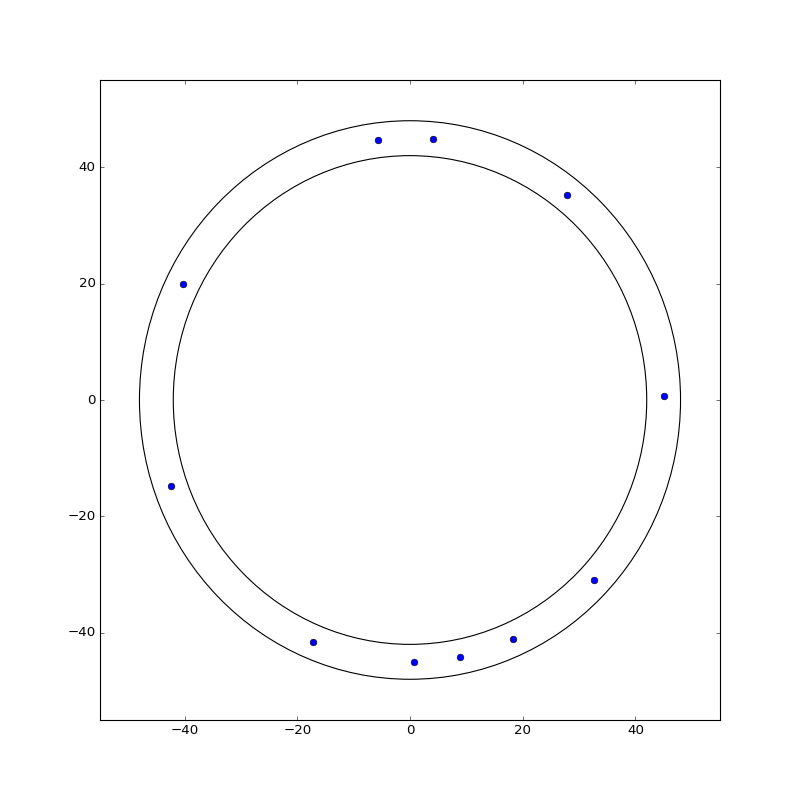

In [ ]:
import time

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

# initial x and y data
x = 45 * np.cos(pos_rad)
y = 45 * np.sin(pos_rad)

li1, = ax.plot(x[0,4:], y[0,4:], 'o')
li2, = ax.plot(x[0,:4], y[0,:4], 'o', c='r')

# draw circular road
circle1 = plt.Circle((0, 0), 42, color='k', fill=False)
circle2 = plt.Circle((0, 0), 48, color='k', fill=False)
ax.add_artist(circle1)
ax.add_artist(circle2)

# draw and show it
fig.canvas.draw()
plt.xlim([-55,55])
plt.ylim([-55,55])
plt.show(block=False)

# loop to update the data
for i in range(1,x.shape[0],10):
    # set the new data
    li1.set_xdata(x[i,pos_rad[i,:]!=0])
    li1.set_ydata(y[i,pos_rad[i,:]!=0])
    li2.set_xdata(x[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    li2.set_ydata(y[i,pos_rad[i,:len(model.ind_cars_const)]!=0])
    
    fig.canvas.draw()
    #time.sleep(0.05)

### Position Profile (Time-space diagram)

In [ ]:
pos_absolute.shape

<IPython.core.display.Javascript object>


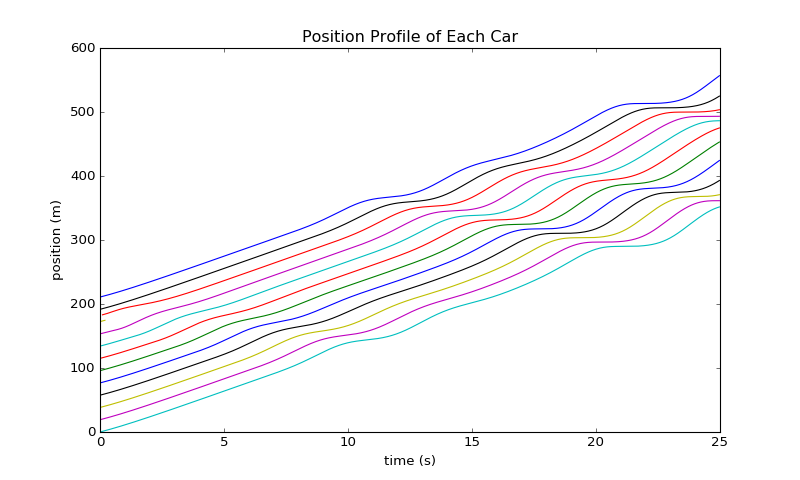

In [9]:
# Plot all cars at once, but for a snippet of the overall simulation run
step_min, step_max = 0, 1000  # start
# step_min, step_max = 19000, 20000  # end

t = np.arange(0, t_final+dt, dt)

plt.figure(figsize=(10,6))

# i is each vehicle that ever exists in the simulation
for i in range(int(pos_absolute.shape[1])):
    valid_ind = pos_absolute[step_min:step_max,i]!=0
    plt.plot(t[step_min:step_max][valid_ind], pos_absolute[step_min:step_max,:][valid_ind][:,i])

plt.title("Position Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('position (m)')
plt.show()

### Headway Profile (Convergence plot)

In [9]:
print("Average number of cars (nbar):", np.average(n_cars_cur))
# TODO compute the equilibrium headway and velocity at nbar
print("h_nbar^*:")
print("v_nbar^*:")

Average number of cars (nbar): 10.7955334574
h_nbar^*:
v_nbar^*:


<IPython.core.display.Javascript object>


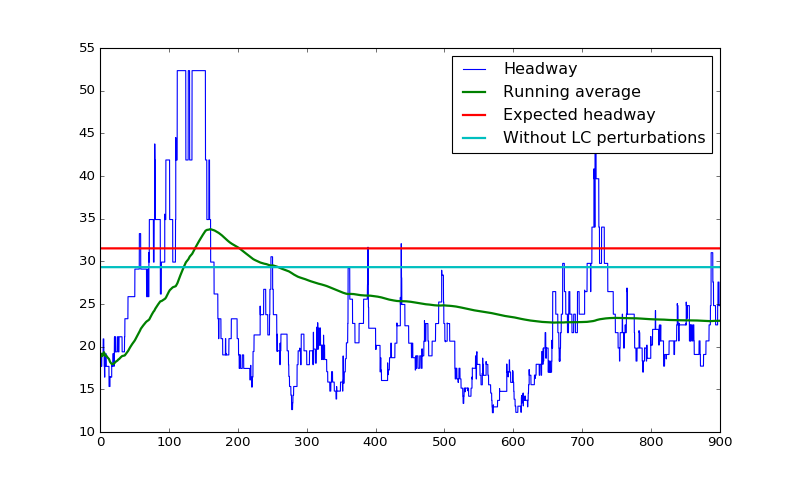

<IPython.core.display.Javascript object>


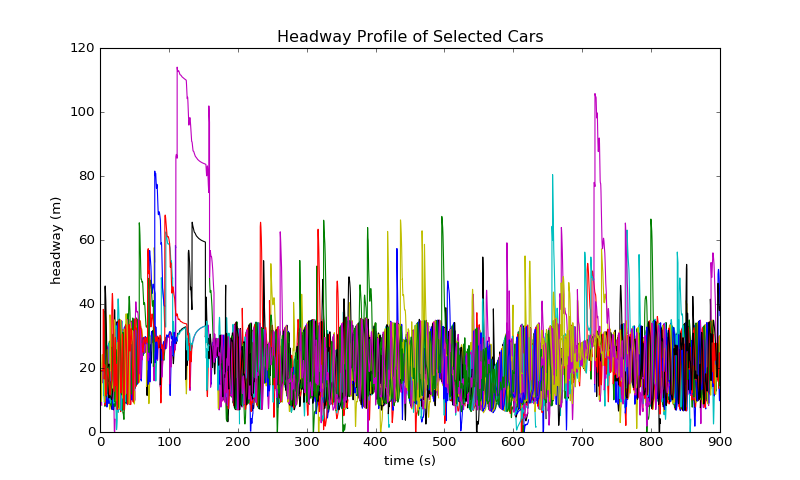

In [10]:
t = np.arange(0, t_final+dt, dt)

# calculate average headway
avg_headway = np.zeros(headway.shape[0])
convg_headway = np.zeros(headway.shape[0])

for i in range(avg_headway.shape[0]):
    avg_headway[i] = np.sum(headway[i,:])/sum(headway[i,:]!=0)
    convg_headway[i] = np.average(avg_headway[0:i])
    
plt.figure(figsize=(10,6))

plt.plot(t[avg_headway!=0], avg_headway[avg_headway!=0], label="Headway")
plt.plot(t[convg_headway!=0], convg_headway[convg_headway!=0], label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 31.5199, 'r', label='Expected headway', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 230 / 7.8449, 'c', label='Without LC perturbations', linewidth=2)

plt.legend(loc=1)
plt.figure(figsize=(10,6))

for i in range(headway.shape[1]):
    plt.plot(t[headway[:,i]!=0], headway[headway[:,i]!=0][:,i])

plt.title("Headway Profile of Selected Cars")
plt.xlabel('time (s)')
plt.ylabel('headway (m)')
plt.show()

### Velocity Profile

16.7282110601


<IPython.core.display.Javascript object>


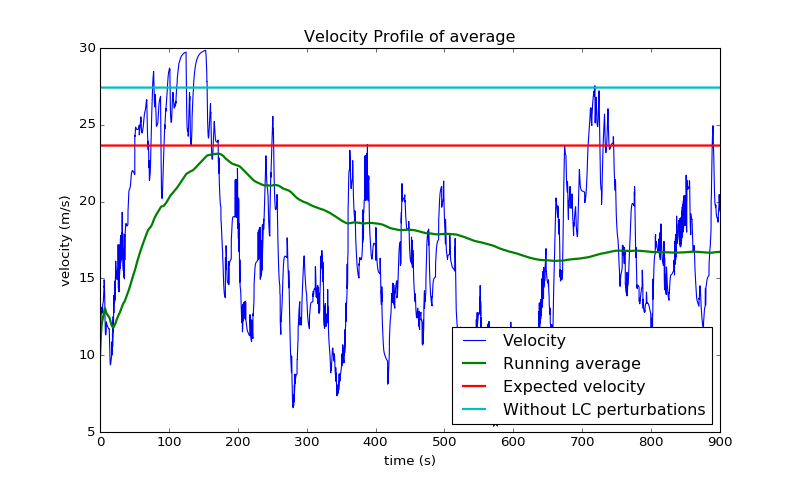

<IPython.core.display.Javascript object>


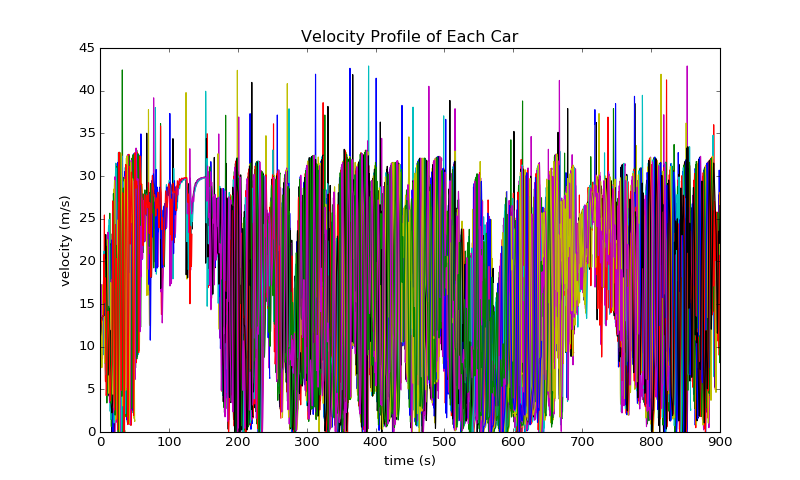

In [11]:
t = np.arange(0, t_final+dt, dt)

avg_vel = np.zeros(vel.shape[0])
convg_vel = np.zeros(vel.shape[0])
for i in range(avg_vel.shape[0]):
    avg_vel[i] = np.sum(vel[i,:])/sum(vel[i,:]!=0)
    convg_vel[i] = np.average(avg_vel[0:i])

print(convg_vel[-1])
plt.figure(figsize=(10,6))
plt.plot(t[avg_vel!=0], avg_vel[avg_vel!=0], label="Velocity")
plt.plot(t[convg_vel!=0], convg_vel[convg_vel!=0], label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 23.6504, 'r', label='Expected velocity', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 27.4224, 'c', 
         label='Without LC perturbations', linewidth=2)

plt.legend(loc=4)
plt.title("Velocity Profile of average")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()    
    
plt.figure(figsize=(10,6))

for i in range(vel.shape[1]):
    plt.plot(t[vel[:,i]!=0], vel[vel[:,i]!=0,i])

plt.title("Velocity Profile of Each Car")
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')
plt.show()

### Number of Cars vs. Time

9.48722222222


<IPython.core.display.Javascript object>


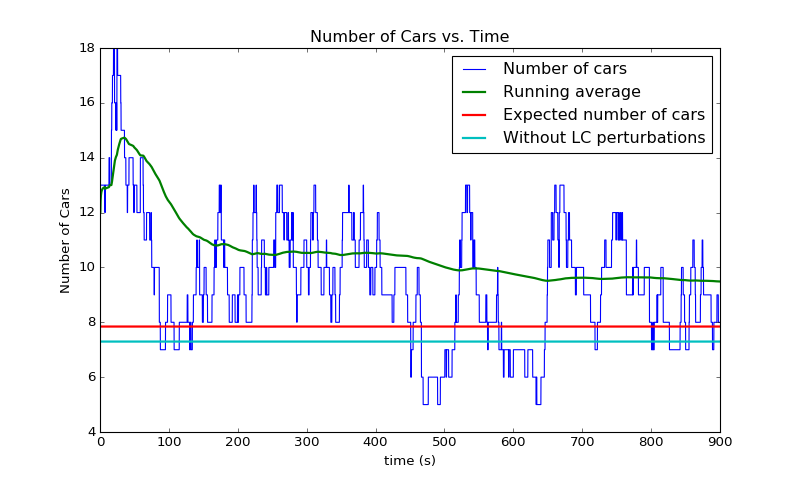

In [10]:
#EVL = params['s0']+params['lc']   # effective vehicle length
#max_occupancy = params['lr']/EVL  # maximum number of cars on the road

t = np.arange(0, t_final+dt, dt)


# calculate the average number of cars over time
avg_cars = np.zeros(n_cars_cur.shape[0])
for i in range(avg_cars.shape[0]):
    avg_cars[i] = np.average(n_cars_cur[0:i])
    
print(avg_cars[-1])  


plt.figure(figsize=(10,6))

plt.plot(t,n_cars_cur, label='Number of cars')
plt.plot(t,avg_cars, label='Running average', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 7.8449, 'r', label='Expected number of cars', linewidth=2)

plt.plot(t,np.ones(t.shape[0]) * 230 / (31.5199 + params['lc']), 'c', 
         label='Without LC perturbations', linewidth=2)

# max occupancy is over 160, I recommend not putting
#plt.plot(t,max_occupancy*np.ones(len(t)))

plt.legend()

plt.title("Number of Cars vs. Time")
plt.xlabel('time (s)')

plt.ylabel('Number of Cars')
plt.show()

## Number of Lane Changes

<IPython.core.display.Javascript object>


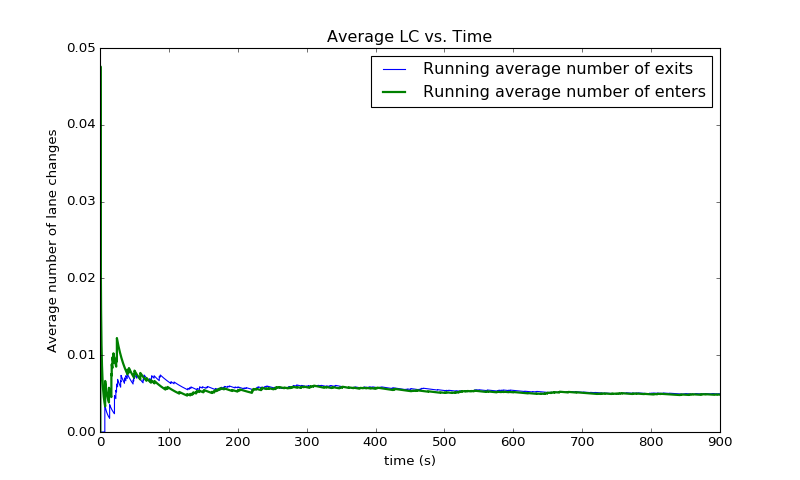

<IPython.core.display.Javascript object>


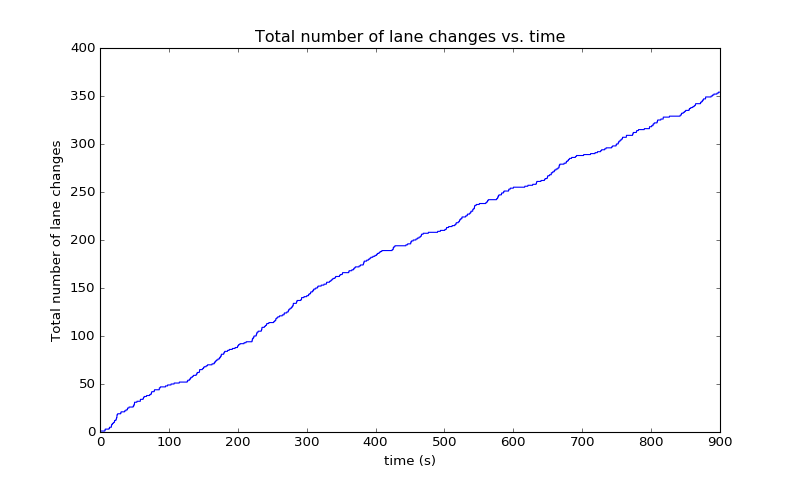

<IPython.core.display.Javascript object>


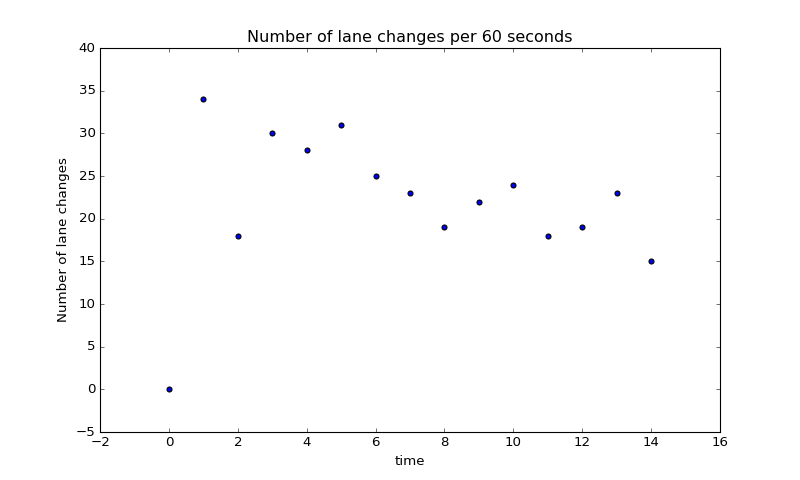

In [21]:
t = np.arange(0, t_final+dt, dt)

# calculate the average number of lane changes
avg_exits = np.zeros(n_cars_cur.shape[0])
avg_enters = np.zeros(n_cars_cur.shape[0])
total_lc = np.zeros(n_cars_cur.shape[0])
unit = 60; 
lc_per_min = np.zeros(np.floor(len(t)/(unit/dt)))
for i in range(len(t)):
    avg_exits[i] = np.average(num_exits[0:i])
    avg_enters[i] = np.average(num_enters[0:i])
    total_lc[i] = np.sum(num_enters[0:i]) + np.sum(num_exits[0:i])

plt.figure(figsize=(10,6))
plt.plot(t,avg_exits, label='Running average number of exits')
plt.plot(t,avg_enters, label='Running average number of enters', linewidth=2)
plt.legend()
plt.title("Average LC vs. Time")
plt.xlabel('time (s)')
plt.ylabel('Average number of lane changes')

plt.figure(figsize=(10,6))
plt.plot(t, total_lc)
plt.title('Total number of lane changes vs. time')
plt.xlabel('time (s)')
plt.ylabel('Total number of lane changes')

# plot lane changes per minute
min_step = int(np.floor(unit/dt))
for i in range(int(np.floor(len(t)/(unit/dt)))):
    lc_per_min[i] = np.sum(num_enters[(i-1)*min_step:i*min_step]) + np.sum(num_exits[(i-1)*min_step:i*min_step])
    
plt.figure(figsize=(10,6))
plt.scatter(range(int(np.floor(len(t)/(unit/dt)))), lc_per_min)
plt.title('Number of lane changes per {0} seconds'.format(unit))
plt.xlabel('time')
plt.ylabel('Number of lane changes')

plt.show()

In [16]:
lane_change_df

,distance_headway,lag_velocity,lead_velocity,time,type,velocity
0,8.846154,NaN,2.831659,2.0,Exit,2.831659
1,8.846154,NaN,1.864427,3.0,Exit,1.864427
2,8.846154,NaN,1.864427,3.0,Exit,1.864427
3,8.846154,NaN,1.245103,6.0,Exit,1.245103
4,16.594367,NaN,1.218543,7.0,Exit,4.799436
5,9.472398,NaN,2.484343,9.0,Exit,1.050563
6,9.966046,NaN,1.050563,9.0,Exit,3.271118
7,5.829097,NaN,2.932511,18.0,Exit,-4.468388
8,11.029519,NaN,2.773886,18.0,Exit,3.228877
9,8.291081,NaN,3.172582,21.0,Exit,-1.436925


In [17]:
th = np.arange(0,100,0.1)

mu_lc = 3 #1.9802 - 32.7937*density
sigma_lc = 0.4047

mu_th = 2.9699 #2.05 - 48.53*density
sigma_th = 0.455

# normalization constant
C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
    * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
           (-2*sigma_th**2+2*sigma_lc**2)) \
    / np.sqrt(2*np.pi)

p_appear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))    
    
mu_lc = 2.8202 #2.0718 - 51.96*density
sigma_lc = 0.44

mu_th = 2.9699 #2.05 - 48.53*density
sigma_th = 0.455

# normalization constant
C = np.sqrt(1/sigma_lc**2-1/sigma_th**2) \
    * np.exp(((mu_lc-mu_th)**2 - 2*mu_th*sigma_lc**2 + 2*mu_lc*sigma_th**2 + sigma_th**2*sigma_lc**2)/
           (-2*sigma_th**2+2*sigma_lc**2)) \
    / np.sqrt(2*np.pi)

p_disappear = C*np.exp((np.log(th)-mu_th)**2/(2*sigma_th**2) - (np.log(th)-mu_lc)**2/(2*sigma_lc**2))

plt.figure()
plt.plot(nc,p_disappear)
plt.plot(nc,p_appear)
plt.legend(['disappear','appear'])
plt.xlim([0,100])
plt.show()

<IPython.core.display.Javascript object>

NameError: name 'nc' is not defined

In [ ]:
nc = 230/th

In [ ]:
nc

In [ ]:
p_appear[11*10]